In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
import nengo.spa as spa

In [8]:
D = 16
vocab = spa.Vocabulary(D)

A = vocab.parse('A').v
B = vocab.parse('B').v

rate_A = 0.8
rate_B = 1.0 - rate_A

N = 1000
inputs = np.zeros((N, D)) + A
inputs[int(N*rate_A):] = B

np.random.shuffle(inputs)

t_present = 0.1

model = nengo.Network()
with model: 
    # the actual stimulus we're seeing right now
    stim = nengo.Node(lambda t: inputs[int(t/t_present) % N])
    
    
    # our expectations based on previous experience
    #  (learning this would be doable, but is outside the scope of the current model)
    expectation = nengo.Node(A*rate_A + B*rate_B)
    
    
    p_stim = nengo.Probe(stim)
    
    # network to compute the similarity between the stimulus and our expectation
    product = nengo.networks.Product(n_neurons=100, dimensions=D, input_magnitude=1.0)
    
    similarity = nengo.Node(None, size_in=1)
    nengo.Connection(expectation, product.input_a, synapse=None)
    nengo.Connection(stim, product.input_b, synapse=None)
    nengo.Connection(product.output, similarity, transform=np.ones((1, D)))
    
    p_similarity = nengo.Probe(similarity)
    
    # neurons to represent how surprised we are (surprise = 1-similarity)
    surprise = nengo.Ensemble(n_neurons=100, dimensions=1, encoders=nengo.dists.Choice([[1]]))
    nengo.Connection(product.output, surprise, transform=-np.ones((1, D)))
    bias = nengo.Node(1)
    nengo.Connection(bias, surprise)
    
    p_surprise = nengo.Probe(surprise)
    p_surprise_neurons = nengo.Probe(surprise.neurons)
    
    
    
sim = nengo.Simulator(model)
with sim:
    sim.run(2)
    
    
    

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [9]:
import nengo_gui.ipython
nengo_gui.ipython.IPythonViz(model, 'surprise.cfg')

c:\users\terry\documents\github\nengo_gui\nengo_gui\jupyter.py:69: ConfigReuseWarning: Reusing config. Only the most recent visualization will update the config.
  "Reusing config. Only the most recent visualization will "


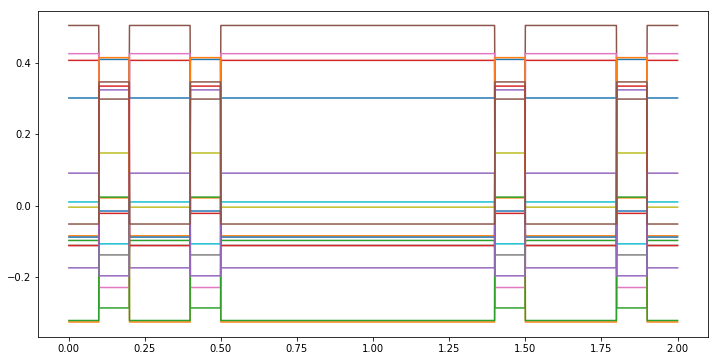

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(sim.trange(), sim.data[p_stim])
plt.show()

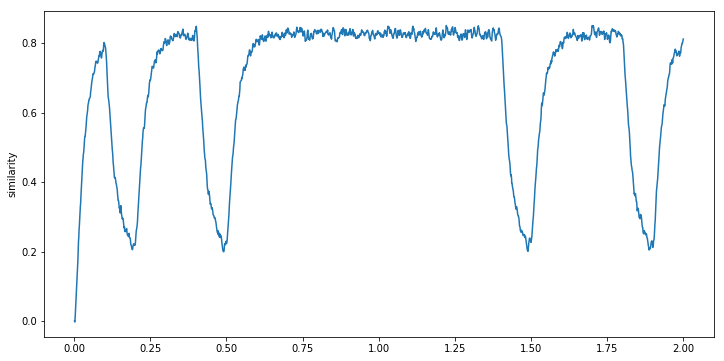

In [11]:
syn = nengo.synapses.Lowpass(0.03)
plt.figure(figsize=(12, 6))
plt.plot(sim.trange(), syn.filt(sim.data[p_similarity]))
plt.ylabel('similarity')
plt.show()

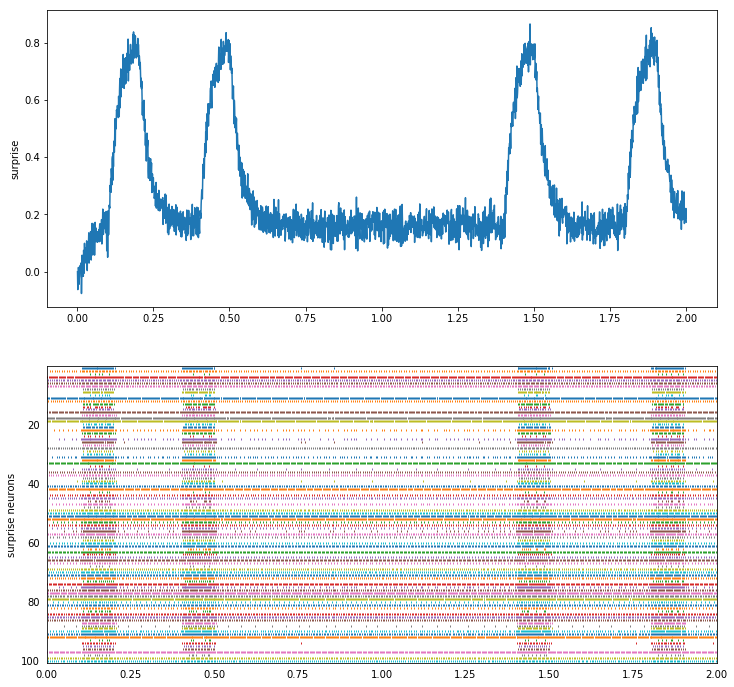

In [12]:
import nengo.utils.matplotlib
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(sim.trange(), syn.filt(sim.data[p_surprise]))
plt.ylabel('surprise')
plt.subplot(2, 1, 2)

plt.ylabel('surprise neurons')
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_surprise_neurons])